In [44]:
import sys
!conda install --yes --prefix {sys.prefix} tensorflow

Solving environment: ...working... done

# All requested packages already installed.



In [45]:
!pip install --prefix {sys.prefix} tf-nightly

In [73]:
import numpy as np 
import pandas as pd 
import os
import cv2

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers


In [74]:
batch_size = 40
img_height = 200
img_width = 200

In [75]:
data = 'C:/Users/issac/OneDrive/Desktop/Documents/UM/2020 2021 Semester 2/WIX3001 SOFT COMPUTING/data'
os.listdir(data)

['without_mask', 'with_mask']

In [76]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)


Found 7554 files belonging to 2 classes.
Using 6044 files for training.


In [77]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/issac/OneDrive/Desktop/Documents/UM/2020 2021 Semester 2/WIX3001 SOFT COMPUTING/data',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 7554 files belonging to 2 classes.
Using 1510 files for validation.


In [78]:
class_names = training_ds.class_names
print(class_names)

['with_mask', 'without_mask']


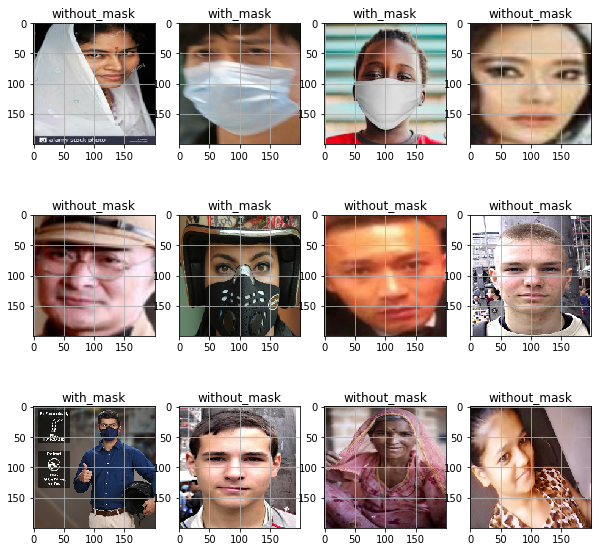

In [72]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [53]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [54]:
## CNN model
MyCnn = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  # Global avg Pooling instead of flatten() as flatten layer will increase the size of your model
  layers.GlobalAveragePooling2D(),
  layers.Dense(256, activation='relu'),
  layers.Dense(2, activation= 'softmax')
])

In [55]:
MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [79]:
MyCnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 128)      

In [56]:
## CNN Training
retVal = MyCnn.fit(training_ds, validation_data= testing_ds, epochs = 15)

Epoch 1/15
152/152 [==============================] - 215s 1s/step - loss: 0.5760 - accuracy: 0.6990 - val_loss: 0.5575 - val_accuracy: 0.7258
Epoch 2/15
152/152 [==============================] - 211s 1s/step - loss: 0.5351 - accuracy: 0.7389 - val_loss: 0.5417 - val_accuracy: 0.7278
Epoch 3/15
152/152 [==============================] - 236s 2s/step - loss: 0.5236 - accuracy: 0.7469 - val_loss: 0.5294 - val_accuracy: 0.7430
Epoch 4/15
152/152 [==============================] - 239s 2s/step - loss: 0.5117 - accuracy: 0.7533 - val_loss: 0.5174 - val_accuracy: 0.7517
Epoch 5/15
152/152 [==============================] - 220s 1s/step - loss: 0.4840 - accuracy: 0.7674 - val_loss: 0.4622 - val_accuracy: 0.7801
Epoch 6/15
152/152 [==============================] - 237s 2s/step - loss: 0.4457 - accuracy: 0.7990 - val_loss: 0.4216 - val_accuracy: 0.8086
Epoch 7/15
152/152 [==============================] - 217s 1s/step - loss: 0.3866 - accuracy: 0.8334 - val_loss: 0.3909 - val_accuracy: 0.8258

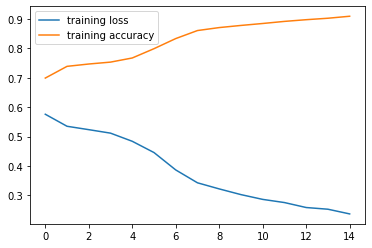

In [57]:
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

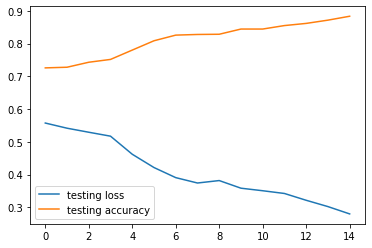

In [66]:
plt.plot(retVal.history['val_loss'], label = 'testing loss')
plt.plot(retVal.history['val_accuracy'], label = 'testing accuracy')
plt.legend()

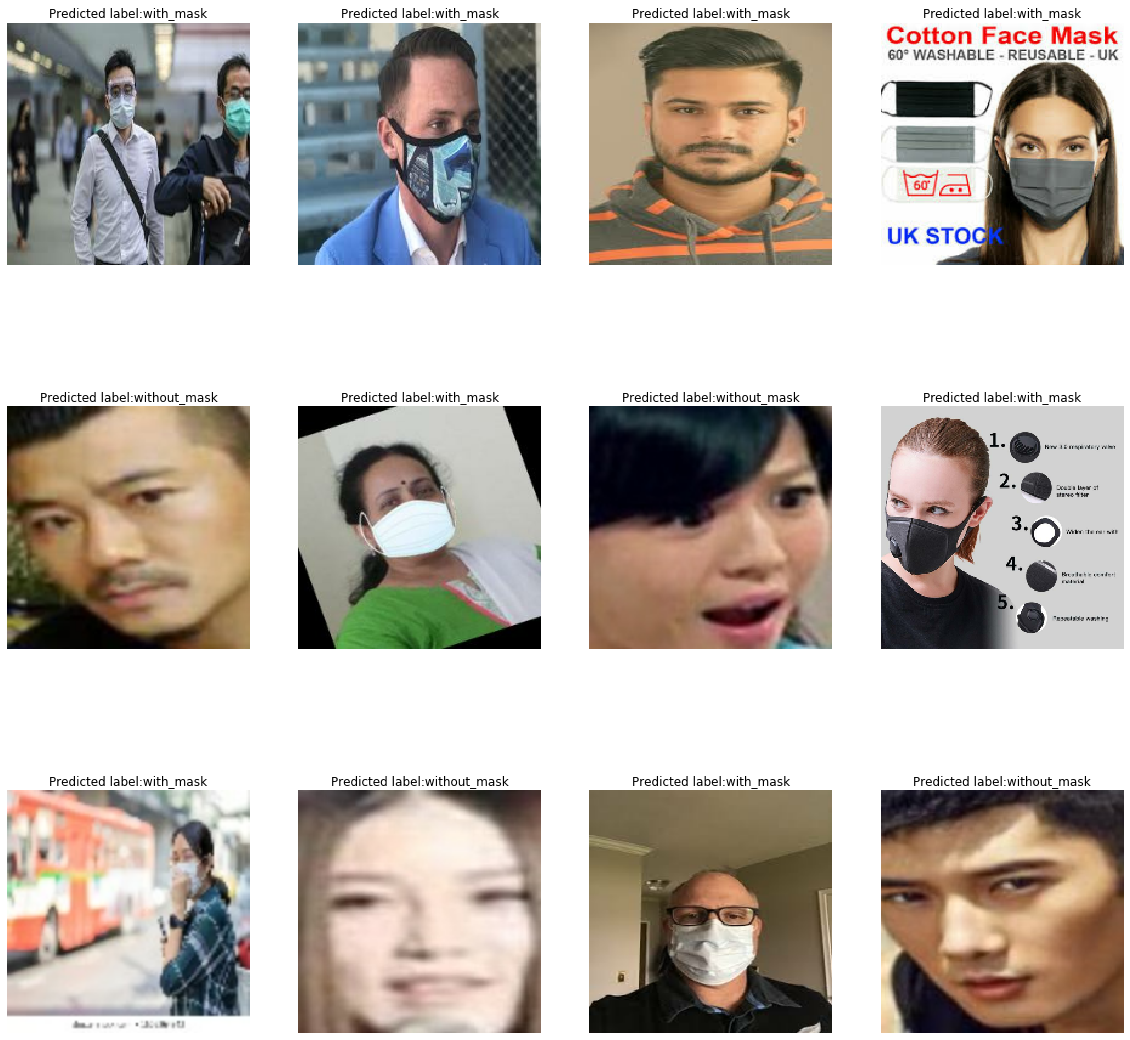

In [81]:
##Prediction of data
plt.figure(figsize=(20, 20))
for images, labels in testing_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
    
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:'+ predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [59]:
def LoadAndDetectObject(path, boxSize = 100, lim = 200):
    #Load image and extract ROI
    img = plt.imread(path)
    img = cv2.resize(img,(200,200))
    numplots = (lim / boxSize)*(lim /boxSize)
    stride = int ((lim - boxSize)/ boxSize)
    
    xCurPos = 0
    yCurPos = 0
    Red = img [:,:,0]
    Blue = img[:,:,1]
    Green = img[:,:,2]
    
    y_pos = 0
    i = 0
    while y_pos < lim:
        x_pos = 0
        while x_pos < lim:
            xCurPos = x_pos
            yCurPos = y_pos
            i += 1
            #Image no mask
            if i > numplots + 1000:
                cv2.putText(img, 'No Mask', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 1)
                plt.imshow(img)
                return
            
            
            r = Red[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            g = Blue[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            b = Green[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            
            ## sanity check
            xx, yy = r.shape
            if xx*yy != boxSize*boxSize:
                x_pos += stride
                continue
            
            #Classifies the image (Mask/ No Mask)
            imageSegment = cv2.merge((r,g,b))
            imageSegment  = np.array(imageSegment, dtype = 'uint8')
            imageSegment = cv2.resize(imageSegment, (lim, lim))
            result = (MyCnn.predict(np.array([imageSegment])))
            probab = max(result.flatten())
            result = (class_names[np.argmax(result)])
            #print(probab)
            
            #Image has mask
            if result == 'with_mask' and probab >= 0.8:
                probab = int (probab * 100) / 100
                #Draw frame 
                img = cv2.rectangle(img, (xCurPos,yCurPos), (xCurPos + boxSize, yCurPos + boxSize), (0,255,0), 1) 
                cv2.putText(img, 'Mask', (xCurPos,yCurPos + boxSize), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 1)
                plt.imshow(img)
                return
            
            
            
            
            x_pos += stride
        y_pos += stride
    
    #Image no mask
    cv2.putText(img, 'No Mask', (100,100), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 1)
    plt.imshow(img)

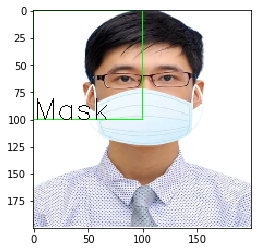

In [60]:
LoadAndDetectObject('C:/Users/issac/Downloads/Images/Chew_Swee_Keat_with_mask.jpg')

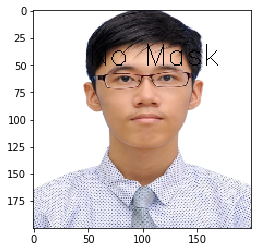

In [61]:
LoadAndDetectObject('C:/Users/issac/Downloads/Images/Chew_Swee_Keat_without_mask.jpg')

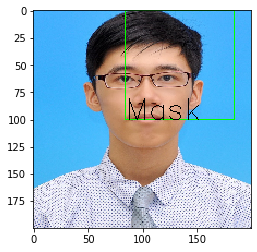

In [62]:
LoadAndDetectObject('C:/Users/issac/Downloads/Images/Chew Swee Keat_blue_without_mask.jpg')

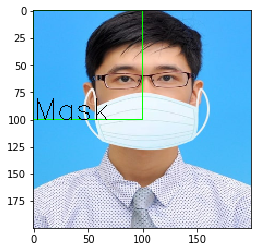

In [63]:
LoadAndDetectObject('C:/Users/issac/Downloads/Images/Chew Swee Keat_blue_with_mask.jpg')

In [64]:
MyCnn.save('Face_Mask_Detector.h5')